# Exercice de code 
Objectif: prédiction des flux passagers-aéroports

## Importation des données et manipulations élémentaires

### Chargement des packages et des données

In [46]:
import numpy as np
import pandas as pd
from pandas import datetime
% matplotlib inline 
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 15, 6

In [47]:
df=pd.read_csv('passenger_data.csv')
df.head()
type(df['DateOfDeparture'][1])
# On convertit directement le string en date
df['DateOfDeparture']=pd.to_datetime(df['DateOfDeparture'])
df.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd
0,2012-10-21,DFW,SFO,14.600000,10.757779,11.575837
1,2012-09-13,LAX,ATL,14.730769,11.808097,13.364304
2,2012-09-04,ORD,IAH,8.470588,10.865349,5.885551
3,2012-08-13,DEN,PHX,8.200000,10.710562,6.292853
4,2012-09-10,ORD,SEA,12.090909,11.498355,9.138662


### Description des variables 

In [48]:
df.describe(include='all')

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd
count,11128,11128,11128,11128.000000,11128.000000,11128.000000
unique,552,20,20,NaN,NaN,NaN
top,2011-11-19 00:00:00,ORD,ORD,NaN,NaN,NaN
freq,32,1311,1364,NaN,NaN,NaN
first,2011-09-01 00:00:00,NaN,NaN,NaN,NaN,NaN
last,2013-03-05 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,11.466842,10.997728,8.635226
std,NaN,NaN,NaN,2.807131,0.998242,2.145805
min,NaN,NaN,NaN,2.625000,3.878108,2.160247
25%,NaN,NaN,NaN,9.523810,10.427055,7.109619


### Etude de la fréquence des observations 

In [49]:
# On compte le nombre de jours entre les dates maximum et minimum
df['DateOfDeparture'].max()-df['DateOfDeparture'].min()
# Ce nombre est bien égal au nombre d'observations uniques de dates. Il y a donc au moins un 
#vol enregistré tous les jours.

Timedelta('551 days 00:00:00')

In [50]:
# On réorganise le dataframe pour l'organiser par date croissante
df=df.sort_values('DateOfDeparture')

In [51]:
# On créé un dataframe qui regroupe par date, pour compter le nombre de vols enregistrés par jour
df_grouped = df.groupby('DateOfDeparture')
df_grouped['Departure'].count().describe()

count    552.000000
mean      20.159420
std        4.087512
min        8.000000
25%       17.000000
50%       20.000000
75%       23.000000
max       32.000000
Name: Departure, dtype: float64

## Résumé des premiers éléments et plan de travail 

### Résumé des premiers éléments
On a donc 11,128 vols enregistrés, en provenance et vers 20 aéroports, entre le 1er septembre 2011 et le 5 mai 2013. Selon les jours, de 8 à 32 vols sont enregistrés, avec une moyenne à 20.2

### Réflexions préliminaires sur le projet
Plusieurs questions peuvent être des questions d'intérêt:
- prédire les flux entrants (respectivement flux sortants) pour chaque aéroport, peu importent les origines (resp. les destinations)
- prédire les flux d'un aéroport A à un aéroport B

## Analyse de série temporelles sur les données agrégées par jour

En première intention, il peut être bon de travailler sur les données agrégées par jour

DateOfDeparture
2011-09-01    2.115703e+06
2011-09-02    2.184757e+06
2011-09-03    5.508294e+05
2011-09-04    5.529308e+05
2011-09-05    2.913265e+06
Name: log_PAX, dtype: float64


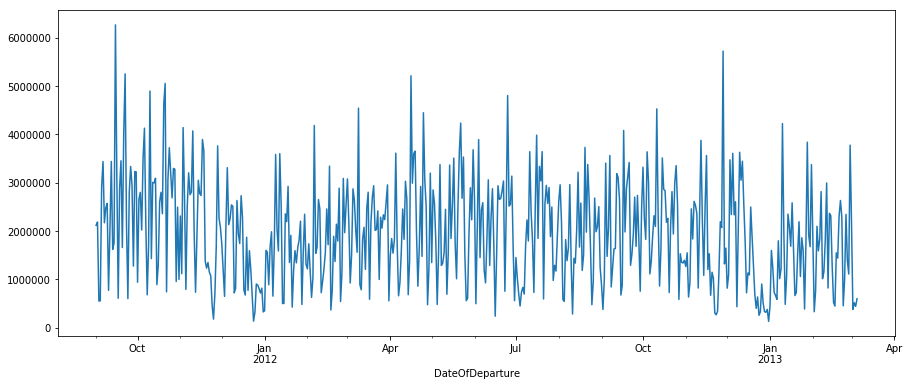

In [52]:
# On repasse en nombre de passagers et plus en log
df['log_PAX']=np.exp(df['log_PAX'])

df_grouped=df.groupby('DateOfDeparture').agg({'log_PAX':sum})

#Après agrégation, on repasse en log
df['log_PAX']=np.log(df['log_PAX'])
df_grouped.to_csv('NewData.csv')

series = pd.read_csv('NewData.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
print(series.head())
series.plot()
plt.show()

La série ne semble pas être stationnaire, on peut vérifier avec les acf.

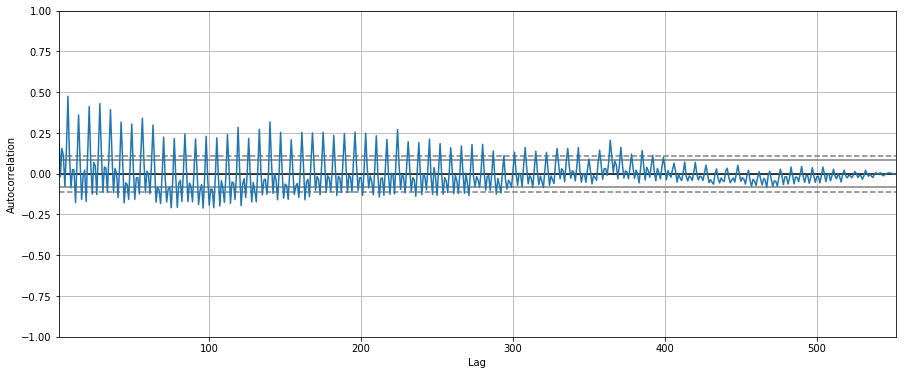

In [53]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)
plt.show()

Il parait nécessaire de désaisonaliser et d'enlever un trend

On teste la saisonalité visuellement et avec Dickey Fuller

In [54]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    # rolling statistics
    rolmean = timeseries.rolling(center=False,window=12).mean()
    rolstd = timeseries.rolling(center=False,window=12).std()

    #Plot:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Moyenne Rolling')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(' Moyenne Rolling & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags','Nb Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

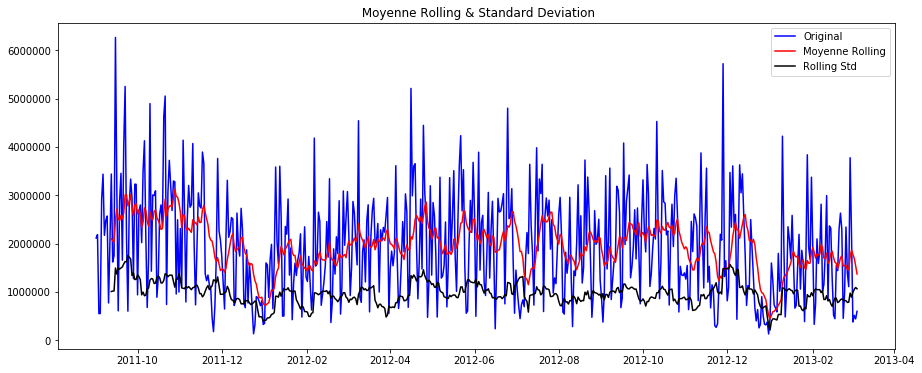

Results of Dickey-Fuller Test:
Test Statistic           -3.712260
p-value                   0.003944
#Lags                    19.000000
Nb Obs                  532.000000
Critical Value (1%)      -3.442702
Critical Value (5%)      -2.866988
Critical Value (10%)     -2.569672
dtype: float64


In [55]:
test_stationarity(series)

Le test de DF semble indiquer une stationarité, on peut donc utiliser les modèles ARIMA. Il semble tout de même qu'il reste une saisonalité (visible au 1er janvier par exemple).

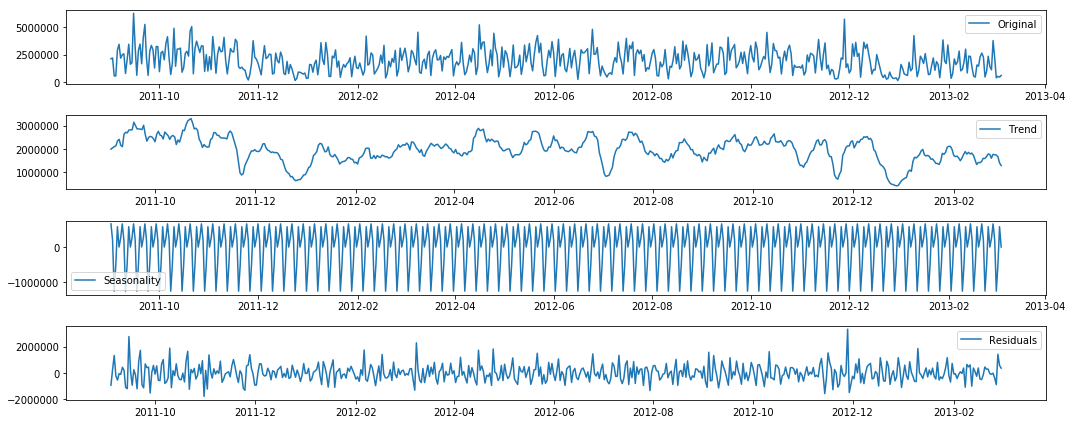

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(series)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(series, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

On observe le comportement des résidus

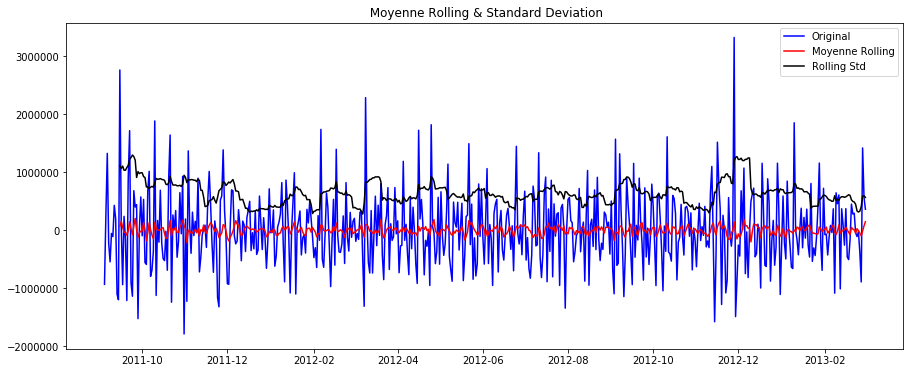

Results of Dickey-Fuller Test:
Test Statistic         -1.019017e+01
p-value                 6.352668e-18
#Lags                   1.800000e+01
Nb Obs                  5.270000e+02
Critical Value (1%)    -3.442820e+00
Critical Value (5%)    -2.867040e+00
Critical Value (10%)   -2.569699e+00
dtype: float64


In [57]:
series_decompose = residual
series_decompose.dropna(inplace=True)
test_stationarity(series_decompose)

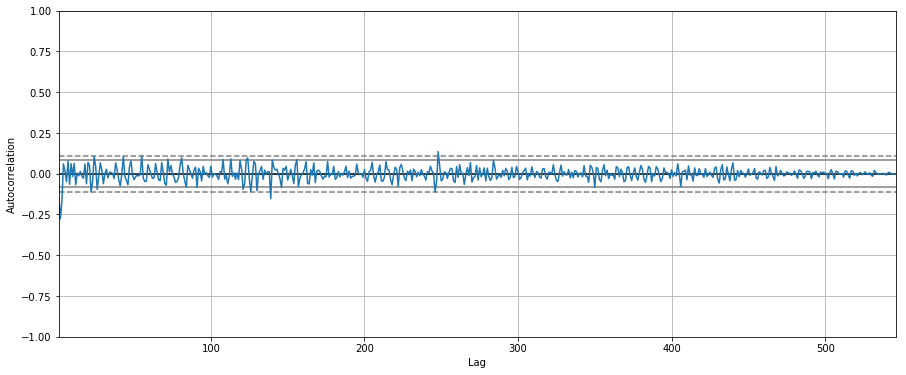

In [58]:
autocorrelation_plot(series_decompose)
plt.show(block=False)

## Etude sur un couple aéroport de départ-aéroport d'arrivée

In [59]:
df['flight'] = df['Departure']+'-'+df['Arrival']
df['flight'].describe(include='all')

count       11128
unique        126
top       DTW-LGA
freq          108
Name: flight, dtype: object

On se restreint au couple le plus fréquent de Detroit à La Guardia

In [60]:
df_ex=df[df['flight']=='DTW-LGA'].copy(deep=True).reset_index(drop=True)
#df_ex.to_csv('ExampleData.csv')
#df_ex = pd.read_csv('ExampleData.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
df_ex.head()
df_ex['DateOfDeparture']=pd.to_datetime(df_ex['DateOfDeparture'])

0n commence par considérer un problème relativement complexe. On souhaite, pour n'importe quel jour dans le futur, sans savoir si un vol est prévu, le nombre de passagers.

### Etude/ajout de features 

#### Délai depuis le dernier vol

On veut étudier le delta entre deux vols, pour comprendre à quel point nos données sont sparses.


In [61]:
df_ex['Delta']=df_ex['DateOfDeparture']-df_ex['DateOfDeparture'].shift(1)
df_ex['Delta'].describe(include='all')

count                       107
mean            5 days 00:00:00
std      4 days 05:07:38.033938
min             1 days 00:00:00
25%             2 days 00:00:00
50%             4 days 00:00:00
75%             7 days 00:00:00
max            25 days 00:00:00
Name: Delta, dtype: object

Ce delta va pouvoir constituer une feature intéressante

#### On complète les missing dates 

In [62]:
from datetime import datetime, timedelta
df_ex.set_index('DateOfDeparture',inplace=True)
df_ex=df_ex.resample('D').first()

df_ex.reset_index(inplace=True)

n=len(df_ex.index)-1
# On corrige le delta
for i in (df_ex.index):
    if pd.isna(df_ex.at[n-i,'WeeksToDeparture'])==True:
        df_ex.at[n-i,'Delta']=df_ex.at[n-i+1,'Delta']+pd.Timedelta('-1 days')

In [63]:
df_ex.head(15)

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd,flight,Delta
0,2011-09-09,DTW,LGA,9.315789,10.977441,6.128736,DTW-LGA,NaT
1,2011-09-10,NaN,NaN,NaN,NaN,NaN,NaN,1 days
2,2011-09-11,NaN,NaN,NaN,NaN,NaN,NaN,2 days
3,2011-09-12,NaN,NaN,NaN,NaN,NaN,NaN,3 days
4,2011-09-13,NaN,NaN,NaN,NaN,NaN,NaN,4 days
5,2011-09-14,DTW,LGA,9.736842,11.278202,8.665654,DTW-LGA,5 days
6,2011-09-15,NaN,NaN,NaN,NaN,NaN,NaN,1 days
7,2011-09-16,NaN,NaN,NaN,NaN,NaN,NaN,2 days
8,2011-09-17,NaN,NaN,NaN,NaN,NaN,NaN,3 days
9,2011-09-18,NaN,NaN,NaN,NaN,NaN,NaN,4 days


#### Jours fériés

On complète en ajoutant les jours fériés

In [64]:
import holidays
us_holidays = holidays.UnitedStates()
df_ex['Holidays']=False
#df_ex['Holidays']=df_ex['Holidays'].apply(lambda x: x in us_holidays)
for i in (df_ex.index):
    df_ex.at[i,'Holidays']=df_ex.at[i,'DateOfDeparture'] in us_holidays

In [65]:
df_ex[df_ex['Holidays']==True].head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd,flight,Delta,Holidays
31,2011-10-10,NaN,NaN,NaN,NaN,NaN,NaN,10 days,True
63,2011-11-11,DTW,LGA,9.421053,11.083177,6.560113,DTW-LGA,11 days,True
76,2011-11-24,DTW,LGA,12.454545,9.998680,10.159337,DTW-LGA,5 days,True
107,2011-12-25,NaN,NaN,NaN,NaN,NaN,NaN,3 days,True
108,2011-12-26,NaN,NaN,NaN,NaN,NaN,NaN,4 days,True


#### Jours de la semaine

On distingue les différents jours de la semaine, en les rendant dummies pour la prédiction.

In [66]:
df_ex['Weekday']=1
for i in (df_ex.index):
    df_ex.at[i,'Weekday']=df_ex.at[i,'DateOfDeparture'].weekday()

df_ex=pd.get_dummies(df_ex, columns=["Weekday"])
df_ex.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd,flight,Delta,Holidays,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,2011-09-09,DTW,LGA,9.315789,10.977441,6.128736,DTW-LGA,NaT,False,0,0,0,0,1,0,0
1,2011-09-10,NaN,NaN,NaN,NaN,NaN,NaN,1 days,False,0,0,0,0,0,1,0
2,2011-09-11,NaN,NaN,NaN,NaN,NaN,NaN,2 days,False,0,0,0,0,0,0,1
3,2011-09-12,NaN,NaN,NaN,NaN,NaN,NaN,3 days,False,1,0,0,0,0,0,0
4,2011-09-13,NaN,NaN,NaN,NaN,NaN,NaN,4 days,False,0,1,0,0,0,0,0


#### Trend

In [67]:
df_ex['Day']=df_ex.index

#### Retravaille la base avant la prédiction

L'essentiel à faire:
- boucher les trous
- transformer le Timedelta en float pour la prédiction
- enlever les logs du nombre de passagers

In [68]:
for i in (df_ex.index):
    if pd.isna(df_ex.at[i,'WeeksToDeparture'])==True:
        df_ex.at[i,'log_PAX']=0
    else:
        df_ex.at[i,'log_PAX']=np.exp(df_ex.at[i,'log_PAX'])

df_ex['Delta_int']= df_ex['Delta']/np.timedelta64(1, 'D')
df_ex.at[0,'Delta_int']=0

df_ex.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd,flight,Delta,Holidays,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Day,Delta_int
0,2011-09-09,DTW,LGA,9.315789,58538.580408,6.128736,DTW-LGA,NaT,False,0,0,0,0,1,0,0,0,0.0
1,2011-09-10,NaN,NaN,NaN,0.000000,NaN,NaN,1 days,False,0,0,0,0,0,1,0,1,1.0
2,2011-09-11,NaN,NaN,NaN,0.000000,NaN,NaN,2 days,False,0,0,0,0,0,0,1,2,2.0
3,2011-09-12,NaN,NaN,NaN,0.000000,NaN,NaN,3 days,False,1,0,0,0,0,0,0,3,3.0
4,2011-09-13,NaN,NaN,NaN,0.000000,NaN,NaN,4 days,False,0,1,0,0,0,0,0,4,4.0


## On fait de la prédiction

On enlève les colonnes qui ne servent pas à ce type de prédiction

In [69]:
df_ex.drop(columns=['Departure','Arrival','flight'],inplace=True)

### Division de l'échantillon

On sélectionne les bonnes features et on divise en apprentissage et test, en prenant garde à ne pas faire de shuffle (séries temporelles).

In [70]:
X=['Delta_int','Holidays','Weekday_1','Weekday_2','Weekday_3','Weekday_4','Weekday_5','Weekday_6','Day']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_ex[X],df_ex['log_PAX'], shuffle = False,random_state=0)

### Random forest

In [71]:
from sklearn.neighbors import KNeighborsRegressor
knnreg = KNeighborsRegressor(n_neighbors = 25).fit(X_train, y_train)

print(knnreg.predict(X_test))
print('R-squared test score: {:.3f}'
     .format(knnreg.score(X_test, y_test)))

[4232.1966772 4232.1966772 4232.1966772 4232.1966772 4232.1966772
 4232.1966772 4232.1966772 4232.1966772 4232.1966772 4232.1966772
 4232.1966772 4232.1966772 4232.1966772 4232.1966772 4232.1966772
 4232.1966772 4232.1966772 4232.1966772 4232.1966772 4232.1966772
 4232.1966772 4232.1966772 4232.1966772 4232.1966772 4232.1966772
 4232.1966772 4232.1966772 4232.1966772 4232.1966772 4232.1966772
 4232.1966772 4232.1966772 4232.1966772 4232.1966772 4232.1966772
 4232.1966772 4232.1966772 4232.1966772 4232.1966772 4232.1966772
 4232.1966772 4232.1966772 4232.1966772 4232.1966772 4232.1966772
 4232.1966772 4232.1966772 4232.1966772 4232.1966772 4232.1966772
 4232.1966772 4232.1966772 4232.1966772 4232.1966772 4232.1966772
 4232.1966772 4232.1966772 4232.1966772 4232.1966772 4232.1966772
 4232.1966772 4232.1966772 4232.1966772 4232.1966772 4232.1966772
 4232.1966772 4232.1966772 4232.1966772 4232.1966772 4232.1966772
 4232.1966772 4232.1966772 4232.1966772 4232.1966772 4232.1966772
 4232.1966

La performance est terrible

### Linear Regression

In [72]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression().fit(X_train, y_train)

print('linear model coeff (w): {}'
     .format(linreg.coef_))
print('linear model intercept (b): {:.3f}'
     .format(linreg.intercept_))
print('R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))

linear model coeff (w): [  594.83542503  -921.6528083  -3436.40405814 -2090.56315991
 -3569.95079241  1984.61338101 -9865.50420671 -8382.08698446
   -11.6566211 ]
linear model intercept (b): 13414.670
R-squared score (training): 0.041
R-squared score (test): -0.056


A nouveau, la performance est mauvaise

### Polynomial Regression

In [73]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(df_ex[X])

X_train, X_test, y_train, y_test = train_test_split(X_poly, df_ex['log_PAX'],
                                                   random_state = 0)
linreg = LinearRegression().fit(X_train, y_train)
print('linear model coeff (w): {}'
     .format(linreg.coef_))
print('linear model intercept (b): {:.3f}'
     .format(linreg.intercept_))
print('R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))

linear model coeff (w): [-4.79616213e-06  2.30127670e+03 -2.21861720e+03  5.30309180e+03
  1.06182215e+04  4.05833701e+03  1.61001103e+04  2.51067617e+03
  2.61536234e+03  5.04720143e+01  5.15617326e+01  1.15223121e+03
 -5.72941496e+02 -1.13449016e+03 -1.24510721e+03 -1.22292710e+03
 -1.09764154e+03 -1.98681324e+03 -5.71246253e+00 -2.21861720e+03
 -2.34392579e+04 -3.29691829e-10  6.91215973e-11  1.83860040e+04
 -4.54747351e-11 -1.19328848e+04  3.15324561e+01  5.30309180e+03
 -1.81898940e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -3.38642169e+01  1.06182215e+04  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.51874826e+01
  4.05833701e+03  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.94311986e+01  1.61001103e+04  0.00000000e+00  0.00000000e+00
 -9.19252272e+01  2.51067617e+03  0.00000000e+00 -2.92619474e+01
  2.61536234e+03 -7.81383032e+00  1.86143007e-03]
linear model intercept (b): -7280.735
R-squared score (training): 0.114
R-squared

Ajouter des termes polynomiaux à la régression ne fait qu'empirer. De toute évidence, puisque les trois techniques échouent, il faut reconsidérer le problème.

### On essaye de comprendre le problème en traçant la time series

0
1        0.000000
2        0.000000
3        0.000000
4        0.000000
5    79078.989579
Name: 58538.58040781915, dtype: float64


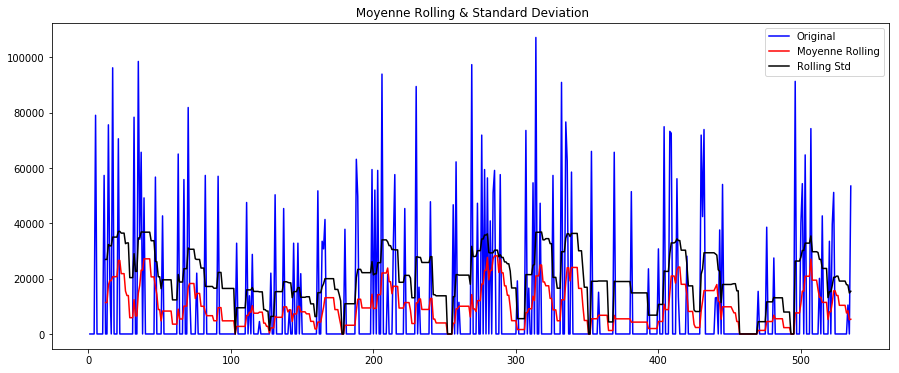

Results of Dickey-Fuller Test:
Test Statistic         -8.005320e+00
p-value                 2.275939e-12
#Lags                   7.000000e+00
Nb Obs                  5.270000e+02
Critical Value (1%)    -3.442820e+00
Critical Value (5%)    -2.867040e+00
Critical Value (10%)   -2.569699e+00
dtype: float64


In [75]:
df_ex.set_index('DateOfDeparture')
df_ex['log_PAX'].to_csv('NewData.csv')

series = pd.read_csv('NewData.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
print(series.head())
test_stationarity(series)

## Bilan
Les résultats sont terriblement mauvais, cela est probablement dû au fait qu'il y a beaucoup trop d'incertitude. On doit prévoir les jours où il y aura des vols, et pour ces jours trouver le bon nombre de passagers, en ayant très peu de features à disposition.
Il faut changer la méthode, on peut par exemple considérer que les dates des vols sont connues par avance, ainsi, on évite de chercher à prévoir des nombres de passagers nuls pour la majorité des dates.

## Nouvelle technique 

On considère donc qu'on connaît maintenant les "DateOfDeparture"

In [76]:
df_ex=df_ex[df_ex['log_PAX']!=0]
df_ex['log_PAX']=np.log(df_ex['log_PAX'])
df_ex.head()

,DateOfDeparture,WeeksToDeparture,log_PAX,std_wtd,Delta,Holidays,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Day,Delta_int
0,2011-09-09,9.315789,10.977441,6.128736,NaT,False,0,0,0,0,1,0,0,0,0.0
5,2011-09-14,9.736842,11.278202,8.665654,5 days,False,0,0,1,0,0,0,0,5,5.0
11,2011-09-20,9.411765,10.956603,6.883484,6 days,False,0,1,0,0,0,0,0,11,6.0
14,2011-09-23,10.857143,11.233584,7.445037,3 days,False,0,0,0,0,1,0,0,14,3.0
15,2011-09-24,10.578947,9.871885,8.623713,1 days,False,0,0,0,0,0,1,0,15,1.0


On adapte les variables explicatives pour pouvoir introduire "WeeksToDeparture"

### Division de l'échantillon

In [77]:
X=(['Delta_int','WeeksToDeparture','std_wtd','Holidays',
    'Weekday_1','Weekday_2','Weekday_3','Weekday_4','Weekday_5','Weekday_6','Day'])

In [78]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_ex[X],df_ex['log_PAX'], shuffle = False,random_state=0)

### Decision Tree

In [83]:
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor(max_depth = 2).fit(X_train, y_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.66
Accuracy of Decision Tree classifier on test set: 0.30


### Random forest

In [79]:
from sklearn.neighbors import KNeighborsRegressor
knnreg = KNeighborsRegressor(n_neighbors = 2).fit(X_train, y_train)

print(knnreg.predict(X_test))
print('R-squared test score: {:.3f}'
     .format(knnreg.score(X_test, y_test)))

[10.7794263 10.7794263 10.7794263 10.7794263 10.7794263 10.7794263
 10.7794263 10.7794263 10.7794263 10.7794263 10.7794263 10.7794263
 10.7794263 10.7794263 10.7794263 10.7794263 10.7794263 10.7794263
 10.7794263 10.7794263 10.7794263 10.7794263 10.7794263 10.7794263
 10.7794263 10.7794263 10.7794263]
R-squared test score: -0.143


La performance est mauvaise avec plusieurs $k$ différents. On abandonne ce modèle.

### Linear Regression

In [80]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression().fit(X_train, y_train)

print('linear model coeff (w): {}'
     .format(linreg.coef_))
print('linear model intercept (b): {:.3f}'
     .format(linreg.intercept_))
print('R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))

linear model coeff (w): [-8.23346346e-03  9.97633432e-02 -2.60504258e-02 -6.63566185e-01
 -2.68688725e-01 -1.30108622e-01 -2.07672298e-01 -2.74868038e-01
 -1.54789599e+00 -5.48671833e-01 -2.48827690e-04]
linear model intercept (b): 10.484
R-squared score (training): 0.662
R-squared score (test): 0.372


Le résultat est bien meilleur qu'avant. On semble toutefois être dans un cas d'overfitting. On va introduire de la régression pénalisée.

### Lasso Regression 

In [81]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linlasso = Lasso(alpha=0.01, max_iter = 10000).fit(X_train_scaled, y_train)

print('lasso regression linear model intercept: {}'
     .format(linlasso.intercept_))
print('lasso regression linear model coeff:\n{}'
     .format(linlasso.coef_))
print('Non-zero features: {}'
     .format(np.sum(linlasso.coef_ != 0)))
print('R-squared score (training): {:.3f}'
     .format(linlasso.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}\n'
     .format(linlasso.score(X_test_scaled, y_test)))

lasso regression linear model intercept: 10.701999140346297
lasso regression linear model coeff:
[-0.          0.44166148  0.         -0.2927378  -0.01537084  0.
  0.         -0.         -1.21296818 -0.1949549   0.        ]
Non-zero features: 5
R-squared score (training): 0.613
R-squared score (test): 0.320



Le résultat n'est pas meilleur, peut être que Ridge peut être plus pertinent

In [82]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from sklearn.linear_model import Ridge

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linridge = Ridge(alpha=0.1).fit(X_train_scaled, y_train)

print('Crime dataset')
print('ridge regression linear model intercept: {}'
     .format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'
     .format(linridge.coef_))
print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test_scaled, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linridge.coef_ != 0)))

Crime dataset
ridge regression linear model intercept: 10.814807966698012
ridge regression linear model coeff:
[-0.12764659  0.87866977 -0.06889194 -0.62544413 -0.2430542  -0.11239182
 -0.17268245 -0.23548308 -1.50321403 -0.51434922 -0.08416085]
R-squared score (training): 0.661
R-squared score (test): 0.370
Number of non-zero features: 11


Idem

### Polynomial Regression couplée à Lasso pour éviter l'overfitting

In [102]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(df_ex[X])

X_train, X_test, y_train, y_test = train_test_split(X_poly, df_ex['log_PAX'],
                                                   random_state = 0)
linreg = Lasso(alpha=0.12).fit(X_train, y_train)

print('(poly deg 2 + lasso) linear model coeff (w):\n{}'
     .format(linreg.coef_))
print('(poly deg 2 + lasso) linear model intercept (b): {:.3f}'
     .format(linreg.intercept_))
print('(poly deg 2 + lasso) R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('(poly deg 2 + lasso) R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))

(poly deg 2 + lasso) linear model coeff (w):
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -6.55667446e-04 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  8.29383696e-06  3.33183444e-03
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.36645327e-02  0.00000000e+00 -8.31898040e-02  0.00000000e+00
  1.32015930e-04  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -7.02356741e-05 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.66297865e-03 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.10625491e-03  0.00000000e+00  0.00000000e

## Choix du modèle
A priori, la régression polynomiale couplée au Lasso est le meilleur choix. Toutefois, bien moins complexe, la régression linéaire simple offre une performance quasiment comparable.